# Stand-alone driver of `LIM_AM_mod.py`

## Import modules

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import os

import calendar
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline
mpl.rc('image', cmap='jet')

import sys
from get_AM_mod import JRA55, CMIP6, ERA5, NAM, SAM, get_y
from tools_AM_mod import cov_lag, find_event
from LIM_AM_mod import LIM, rand_model

from numpy import linalg as la

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")
# D = D_list[model_list.index('HadGEM3-GC31-LL')]
# print(D.name)

# plev = [1000.,  850.,  700.,  500.,  250.,  100.,   50.,   10.]
plev = [850.,  700.,  500.,  250.,  100.,   50.,   10.]
len_slice = 150
offset = 40

## Load data
* y: original data
* y2: original data + a chunck of length `offset` before for composite analysis
* y3: data generated by random model
* **_flt: data filtered by dynamical modes.  

In [2]:
# def get_y(data, index_name):
#     D = NAM(data, index_name=index_name, annual_cycle_fft=2, running_mean=0, save_index=False)
#     p = D.data.level
#     print(D.data.name)

#     y = D.cal_slice(month_start=11, len_slice=150)
#     y = y.astype('float32')
#     t = np.arange(y.shape[1], dtype=y.dtype)

#     y2 = D.cal_slice(month_start=11, len_slice=150, slice_offset=40)
#     y2 = y2.astype('float32')

#     print(f't.shape = {t.shape}, y.shape = {y.shape}, y2.shape = {y2.shape}')

#     return D, p, y, t, y2


# # data = JRA55(name_dir='jra_55', year_start=1958, year_end=2014, plev=plev, name='JRA55')
# # 
# data = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')

# model = 'CESM2'
model = 'FGOALS-g3'
data = CMIP6(name_dir=model, year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')

D, p, y, t, y2 = get_y(data, 'NAM')


Reading from saved data ......
FGOALS-g3 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)


In [3]:
hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = 5,    # use 5 SVDs
                            eig_method = 'pinv',
                            # alpha = 1e-3,
                            ord   = 2,
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

#=========================================
model = LIM(y, hyp_param, verbose=True)

#-----
y3 = rand_model(model.B_r, model.vr_Q, model.w_Q, len_day=150000, dt=0.2, verbose=False, get_x_from_r=model.get_x_from_r)
# model3 = LIM(y3[None, :], hyp_param, verbose=False)

# decomposition by modes
y2_mode = model.mode(y2)
y3_mode = model.mode(y3)
# Define the strat-trop coupling mode
y2_strat = y2_mode[:,:,:,:2].sum(axis=3)
y3_strat = y3_mode[:,:,:2].sum(axis=2)

#-----

hyperpamameters:
{'lim': {'lag_time': 5, 'r_optimal': 5, 'eig_method': 'pinv', 'ord': 2}}
POP e-folding timescales =24.1153, 24.1153, 9.8410, 6.6549, 6.6549
r_opt=5: % of var=99.963203, norm=3.387310, err=0.444621, R2=0.555379, s=1.211069


## Lagged regression

In [4]:
def cal_Ct_p(y, p, p_level):
    k = np.isin(p, p_level)
    Ct_p = np.array([cov_lag(y, lag, -y[:, :, k]) for lag in lags])
    Ct_p_lag = np.array([cov_lag(-y[:, :, k], lag, y) for lag in lags])
    return Ct_p, Ct_p_lag

lag_time = 40
lags = range(lag_time+1)
lags2= range(-lag_time, lag_time+1)
Ct_p0, Ct_p0_lag = cal_Ct_p(y, p, p_level=10)
Ct_p3, Ct_p3_lag = cal_Ct_p(y3[None, :], p, p_level=10)  # using data from the random model

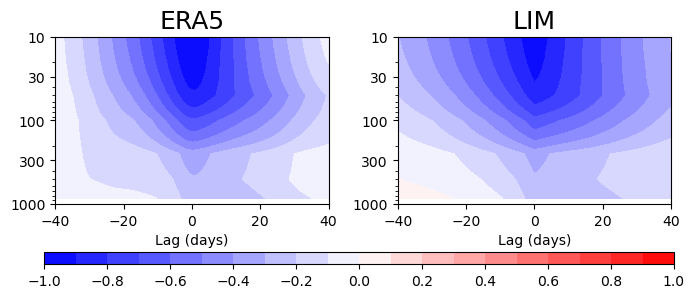

In [5]:
def plot_lag_reg(name, p, Ct_p0, Ct_p0_lag):
    plt.contourf(lags2, p, np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0)).T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=18)

cm = 'bwr' # 'seismic' # 'RdBu_r'
fig = plt.figure(figsize=(7,3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 1, 11
ax1 = fig.add_subplot(1, 2, 1)
plot_lag_reg('ERA5', p, Ct_p0, Ct_p0_lag)
ax1 = fig.add_subplot(1, 2, 2)
plot_lag_reg('LIM', p, Ct_p3, Ct_p3_lag)

plt.tight_layout()
fig.subplots_adjust(bottom=0.3)
cax = fig.add_axes([0.07, 0.1, 0.90, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_reg_ERA5_LIM.pdf', transparent=True)

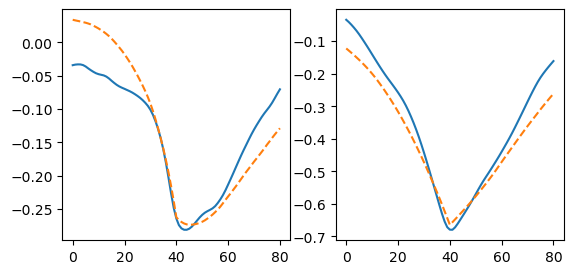

In [6]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 3, 1)
plt.plot(np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0))[:, 0])
plt.plot(np.vstack((np.flipud(Ct_p3_lag[1:,:]), Ct_p3))[:, 0], '--')

ax1 = fig.add_subplot(1, 3, 2)
plt.plot(np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0))[:, 4])
plt.plot(np.vstack((np.flipud(Ct_p3_lag[1:,:]), Ct_p3))[:, 4], '--')


## Weak vortex events

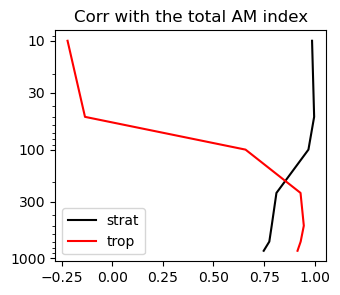

In [7]:
offset = 40
y2_trop = y2 - y2_strat

r2_strat = np.empty(len(p))
r2_trop = np.empty(len(p))
for k in range(len(p)):
    res = stats.pearsonr(y2[:,offset:,k].flatten(), y2_strat[:,offset:,k].flatten())
    r2_strat[k] = res.statistic
    res = stats.pearsonr(y2[:,offset:,k].flatten(), y2_trop[:,offset:,k].flatten())
    r2_trop[k] = res.statistic

fig = plt.figure(figsize=(3.5,3))
plt.plot(r2_strat, p, '-k', label='strat')
plt.plot(r2_trop, p, '-r', label='trop')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title('Corr with the total AM index')
plt.legend()

# plt.savefig('Figs/AM_event_ERA5_corr.pdf', transparent=True)

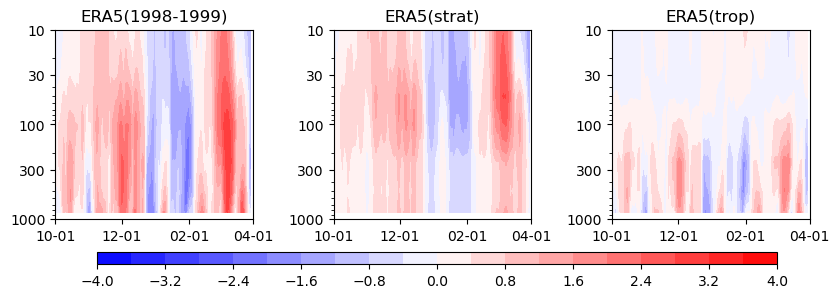

In [8]:
def plot_snapshot(name, p, y2):
    plt.contourf(time, p, y2.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.xlim([time[9], time[-1]])
    plt.xticks(mdates.date2num([dt.date(year, 10, 1), dt.date(year, 12, 1), 
                                dt.date(year+1, 2, 1), dt.date(year+1, 4, 1)]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name)

year = 1998
d_start = mdates.date2num(dt.date(year, 9, 22))
if calendar.isleap(year+1):
    d_end = mdates.date2num(dt.date(year+1, 3, 29))
else:
    d_end = mdates.date2num(dt.date(year+1, 3, 30))
time = np.linspace(d_start, d_end, round(d_end-d_start+1))
yi = year - D.data.year_start

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(8.5, 3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 4, 11
ax1 = fig.add_subplot(1, 3, 1)
plot_snapshot(f"ERA5({year}-{year+1})", p, y2[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 2)
plot_snapshot(f"ERA5(strat)", p, y2_strat[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 3)
y2_trop = y2 - y2_strat
plot_snapshot(f"ERA5(trop)", p, y2_trop[yi, :offset+len_slice, :])

plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_ERA5_snapshot.pdf', transparent=True)

In [9]:
lag_time = 40
threshold = -2
# threshold = 1.5
lags = np.arange(lag_time+1)
lags2= range(-lag_time, lag_time+1)

y2_event, y2_num = find_event(y, p, y2=y2, threshold=threshold, lag_time=lag_time)
y2_strat_event, y2_num = find_event(y, p, y2=y2_strat, threshold=threshold, lag_time=lag_time)

y3_event, y3_num = find_event(y3[None, lag_time:], p, y2=y3[None,:], threshold=threshold, lag_time=lag_time)
y3_strat_event, y3_num = find_event(y3[None, lag_time:], p, y2=y3_strat[None,:], threshold=threshold, lag_time=lag_time)

# of events: 26(0.41)
# of events: 26(0.41)
# of events: 307(307.00)
# of events: 307(307.00)


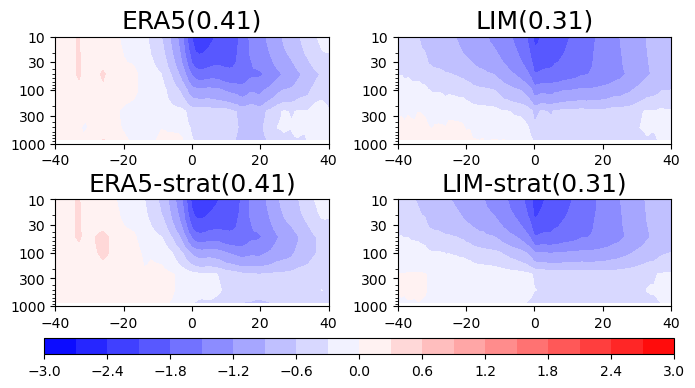

In [10]:
def plot_event(name, p, y0_event):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    # plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=18)

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(7,4))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(2, 2, 1)
plot_event(f"ERA5({y2_num/(2014-1950):.2f})", p, y2_event)

ax1 = fig.add_subplot(2, 2, 2)
plot_event(f"LIM({y3_num/1000:.2f})", p, y3_event)

ax1 = fig.add_subplot(2, 2, 3)
plot_event(f"ERA5-strat({y2_num/(2014-1950):.2f})", p, y2_strat_event)

ax1 = fig.add_subplot(2, 2, 4)
plot_event(f"LIM-strat({y3_num/1000:.2f})", p, y3_strat_event)

plt.tight_layout()
fig.subplots_adjust(bottom=0.22)
cax = fig.add_axes([0.07, 0.1, 0.90, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
# mpl.rcParams.update({'font.size': 18})

# plt.savefig('Figs/AM_event_ERA5_LIM.pdf', transparent=True)

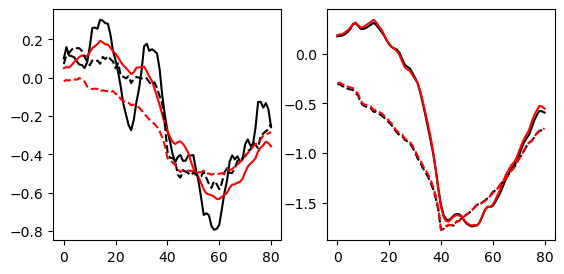

In [11]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 3, 1)
plt.plot(y2_event[:, 0], '-k')
plt.plot(y2_strat_event[:, 0], '-r')
plt.plot(y3_event[:, 0], '--k')
plt.plot(y3_strat_event[:, 0], '--r')

ax1 = fig.add_subplot(1, 3, 2)
plt.plot(y2_event[:, -2], '-k')
plt.plot(y2_strat_event[:, -2], '-r')
plt.plot(y3_event[:, -2], '--k')
plt.plot(y3_strat_event[:, -2], '--r')



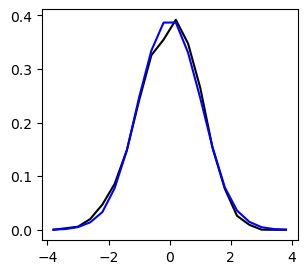

In [12]:
fig = plt.figure(figsize=(3.3,3))
bin_e = np.linspace(-4, 4, 21)
bin_c = 0.5 * (bin_e[:-1] + bin_e[1:])

his_c, _ = np.histogram(y[:, :, 0].flatten(), bins=bin_e, density=True)
his3_c, _ = np.histogram(y3[:, 0], bins=bin_e, density=True)

plt.plot(bin_c, his_c, '-k')
plt.plot(bin_c, his3_c, '-b')
